# Support Vector Machines
## Cristina Gómez Alonso y Carlos Tessier

En este notebook tomaremos como referencia el material del brillante Aurélien Géron, complementado con apuntes de Akranz y recursos actualizados hasta 2025.
Los SVM constituyen una **familia de algoritmos supervisados** que pueden trabajar en **clasificación**, **regresión** (*Support Vector Regression*) e incluso **detección de valores atípicos** (*One-Class SVM*). A pesar de ser un método relativamente “clásico” dentro del Machine Learning, siguen siendo altamente competitivos en datasets pequeños o medianos y con un número elevado de variables.

Los SVM destacan por:

* Ser inicialmente **algoritmos de clasificación binaria** (aunque existen extensiones multiclase, como *one-vs-rest* o *one-vs-one*).
* Construir un **hiperplano de separación** en un espacio N-dimensional que divide los datos en dos clases.
* Buscar siempre la **separación con mayor margen posible**, lo que conduce a modelos generalmente robustos.
* Funcionar especialmente bien en conjuntos con **pocas muestras pero alta dimensionalidad**.
* Poder representar **fronteras no lineales** mediante **kernels** (polinomial, RBF/Gaussiano, sigmoide, etc.).
* Ser sensibles a la necesidad de **escalado de características**.

## 1. Clasificación Lineal con SVM

La idea fundamental de un SVM lineal se entiende observando el siguiente esquema:

<div style="text-align:center;"><img  src="./img/SVM_example.png" /></div>

Si dos clases son **linealmente separables**, cualquier recta (o hiperplano) que las separe *funciona* en entrenamiento. Sin embargo, no todas tienen la misma capacidad de generalizar.
En el gráfico de la izquierda se muestran varios límites de decisión posibles. Algunos separan correctamente las clases, pero están tan ajustados a los puntos que probablemente rendirán mal en datos nuevos.

El modelo de la derecha maximiza la distancia entre el hiperplano y los puntos más cercanos de cada clase. Estas instancias se denominan **vectores de soporte**, porque determinan por completo la frontera. Añadir más puntos lejos de esa “calle” no cambiará el hiperplano.

La búsqueda del hiperplano que genere la “calle más ancha posible” recibe el nombre de:

### **Clasificación de margen máximo (Large Margin Classification)**

Este enfoque tiende a producir clasificadores robustos porque evita decisiones demasiado dependientes de unos pocos puntos ruidosos (salvo que estos queden justo en el margen, algo que veremos a continuación).

Es importante recordar que:

* Un hiperplano en N dimensiones es un objeto de dimensión N−1.
* La frontera depende únicamente de los vectores de soporte.
* Si las características están en **escalas distintas**, el margen puede distorsionarse gravemente. Por eso en SVM es **obligatorio estandarizar** o normalizar.

---

### 1.1. Clasificación de margen suave (*Soft Margin Classification*)

El caso ideal sería encontrar un hiperplano que deje **todas las muestras bien clasificadas y fuera del margen**. Esto se denomina **Hard Margin SVM**, pero tiene dos problemas serios:

1. Solo funciona si los datos son perfectamente separables.
2. Es extremadamente sensible al ruido y a los *outliers*.

<div style="text-align:center;"><img style="width:66%;" src="./img/Hard_Margin_Classifier.png" /></div>

Para superar estas limitaciones surge la **Clasificación de margen suave**, en la que permitimos infracciones del margen pero **las penalizamos** mediante el hiperparámetro `C`.


<div style="text-align:center;"><img style="width:66%;" src="./img/Soft_to_Hard_Street.png" /></div>

Interpretación práctica de `C`:

* **C grande ⇒ margen rígido**. Se penaliza mucho cada error, riesgo de *overfitting*.
* **C pequeño ⇒ margen flexible**. Se aceptan errores para ganar generalización.

En 2025, además, conviene recordar que:

* Para problemas **lineales** y datasets medianos, `LinearSVC` (basado en optimización lineal) es mucho más rápido que `SVC(kernel='linear')`.
* `LinearSVC` no usa *hinge loss* estándar por defecto, sino una variante optimizada.
* Si queremos probabilidades, ni `LinearSVC` ni `SVC` lineal las producen directamente; es necesario usar **calibradores como Platt scaling o CalibratedClassifierCV**.

---

## Ejemplo práctico con Scikit-learn

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

### 1. Carga del dataset Iris

In [2]:
iris = datasets.load_iris()

In [3]:
iris['data'].shape

(150, 4)

El dataset Iris tiene:

* 150 muestras
* 4 características:

  * Sepal Length
  * Sepal Width
  * Petal Length
  * Petal Width
* 3 clases: *Setosa*, *Versicolor* y *Virginica*.

Para simplificar el problema y poder visualizarlo luego, nos quedamos solo con **Petal Length** (longitud del pétalo) y **Petal Width** (anchura del pétalo), y lo convertimos en un problema **binario**:

In [4]:
# Seleccionamos las características de la longitud y anchura del pétalo
X = iris['data'][:, [2,3]]  # Petal Length, Petal Width
# Buscamos clasificar si la planta es del tipo Iris Virginica (1) o no (0) 
y = (iris['target'] == 2).astype(np.float64)  # Iris Virginica
X.shape, y.shape

((150, 2), (150,))

Esto nos deja con un problema de clasificación:
→ ¿La flor es **Virginica** (1) o **no Virginica** (0) ?

### 2. Por qué usamos un Pipeline

Antes de entrenar un SVM necesitamos escalar las características porque:

* Los SVM se basan en distancias (el margen depende de ellas).
* Sin escalado, las features con valores grandes dominarían completamente el cálculo.

Además, un **pipeline** garantiza que:

* El escalado se entrena SOLO con datos de entrenamiento.
* La transformación se aplica correctamente en test y predicción futura.
* Se evita "contaminación" entre fases.

---



### 3. Creación del pipeline con SVM linea

#### **StandardScaler**

* Resta la media y divide por la desviación estándar.
* Hace que todas las características tengan media 0 y varianza 1.
* Es imprescindible para que el margen del SVM sea correcto.

#### **LinearSVC**

Es la implementación eficiente del SVM lineal basada en optimización convexa.

Los hiperparámetros importantes:

* **C=1**

  * Controla cuánta penalización reciben los errores.
  * C grande = margen rígido, riesgo de sobreajuste.
  * C pequeño = margen flexible, mayor generalización.

* **loss='hinge'**

  * Usa la función de pérdida típica del SVM.
  * Alternativa: `'squared_hinge'` (más suave, pero puede castigar más fuerte los errores).

---

In [5]:
svm_clf = Pipeline([
    ('Scaler', StandardScaler()),
    ('Linear_svc', LinearSVC(C=1, loss='hinge'))
])

---

### 4. Entrenamiento del modelo

In [6]:
svm_clf.fit(X, y)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Linear_svc', LinearSVC(C=1, loss='hinge'))])

#### ¿Qué ocurre internamente?

1. El pipeline calcula media y desviación de cada característica (solo sobre X).
2. Reescala los datos.
3. `LinearSVC` busca el hiperplano con **máximo margen** que separe las clases.
4. Identifica los **vectores de soporte**, las muestras que definen la frontera.

En este punto el modelo ya está entrenado.

### 5. Predicción con el modelo entrenado


In [7]:
svm_clf.predict([[5.5, 1.7], [2.0, 1.8]])

array([1., 0.])

### Explicación paso a paso:

El pipeline `svm_clf` hace:

1. Toma las muestras nuevas.
2. Aplica el *mismo escalado* aprendido durante entrenamiento.
3. Pasa los datos escalados al SVM.
4. El SVM calcula en qué lado del hiperplano quedan.
5. Devuelve 0 o 1:

* **1** → El modelo cree que es *Virginica*.
* **0** → El modelo cree que no lo es.

### Importante: Probabilidades

A diferencia de la regresión logística, los SVM **no generan probabilidades** de forma nativa.
Para obtener probabilidades calibradas:

In [8]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_svm = CalibratedClassifierCV(svm_clf, method='sigmoid')  
calibrated_svm.fit(X, y)
calibrated_svm.predict_proba([[5.5, 1.7]])

array([[0.28770798, 0.71229202]])

Este procedimiento aplica *Platt scaling*, que ajusta una sigmoide al margen generado por el SVM.


## 2. Clasificación no Lineal con SVM

En muchos conjuntos de datos reales, las clases **no pueden separarse mediante un hiperplano lineal**, incluso aunque apliquemos margen suave. Un enfoque clásico consiste en **añadir características no lineales**, por ejemplo, términos polinómicos. Al transformar el espacio (aunque no cambiemos los datos visualmente), las clases pueden volverse separables linealmente.


![SVM](./img/img.png)

Esta idea se aprecia en la siguiente figura: un conjunto no lineal en 1D se vuelve linealmente separable al añadir una nueva característica $ x_2 = x_1^2 $.

<div style="text-align:center;"><img style="width:66%;" src="./img/nonlinear_to_linear.png" /></div>

### 2.1. Generación del dataset Moons

Veamos a continuación como implementar esta idea usando scikit-learn con el dataset moons. Este dataset está formado por conjuntos de puntos (cuyo número es configurable, en este caso, será de 100) dispuestos en el plano formando dos lunas opuestas::

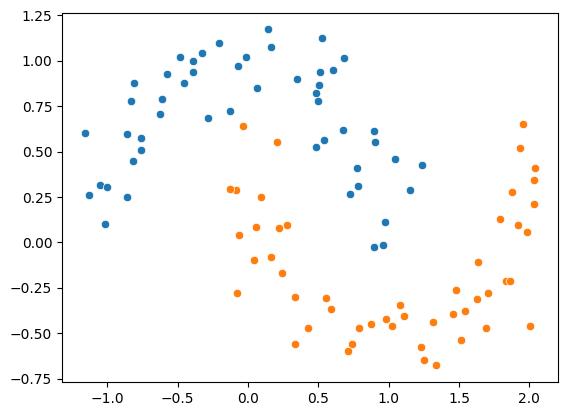

In [9]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15)
import seaborn as sns
Cx = X[:, 0]
Cy = X[:, 1]

sns.scatterplot(x=X[y == 0, 0],y=X[y == 0, 1]);
sns.scatterplot(x=X[y == 1, 0],y=X[y == 1, 1]);

* **make_moons** genera dos regiones con forma de media luna.
* `noise=0.15` añade ruido para que el problema sea más realista (¡sin ruido sería demasiado fácil!).
* Este tipo de dataset **no puede separarse con un SVM lineal**, aunque se ajuste C → ∞.

Esto motiva técnicas no lineales.


### 2.2. SVM con características polinómicas (sin kernels)

Antes de llegar al *kernel trick*, implementamos la idea “manual”:

> Añadir nuevas características polinómicas → entrenar un SVM lineal en ese espacio ampliado.

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge", max_iter=10000))
])

#### **1) PolynomialFeatures(degree=3)**

Genera automáticamente todas las combinaciones polinómicas hasta grado 3:

* $ x_1 $
* $ x_2 $
* $ x_1^2, x_1 x_2, x_2^2 $
* $ x_1^3, x_1^2 x_2, x_1 x_2^2, x_2^3 $
* … y el término de sesgo $1$

Esto transforma un dataset 2D → 10D.

El SVM lineal ahora intenta separar datos en un espacio de 10 dimensiones, donde sí pueden ser linealmente separables.

#### **2) StandardScaler**

Es fundamental porque:

→ Sin escalado, las variables polinómicas crecen muy rápido y arruinan el margen.
→ SVM necesita siempre trabajar con features escaladas.

#### **3) LinearSVC con C=10**

* C más grande = menos tolerancia al error → frontera más compleja.
* Con datos ruidosos puede sobreajustar.

In [11]:
polynomial_svm_clf.fit(X, y)


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', max_iter=10000))])

In [12]:
polynomial_svm_clf.score(X, y)

0.98

### 2.3. Visualización de la frontera de decisión


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs") 
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel(r"$x_1$", fontsize=16)
    plt.ylabel(r"$x_2$", fontsize=16)
    plt.title("Datos lunares", fontsize=18)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 200)
    x1s = np.linspace(axes[2], axes[3], 200)
    x0, x1 = np.meshgrid(x0s, x1s)

    X_grid = np.c_[x0.ravel(), x1.ravel()]

    # ⚠ LinearSVC NO siempre implementa decision_function para pipelines → depende de versión
    y_pred = clf.predict(X_grid).reshape(x0.shape)

    # Contornos
    plt.contourf(x0, x1, y_pred, alpha=0.2, cmap=plt.cm.brg)

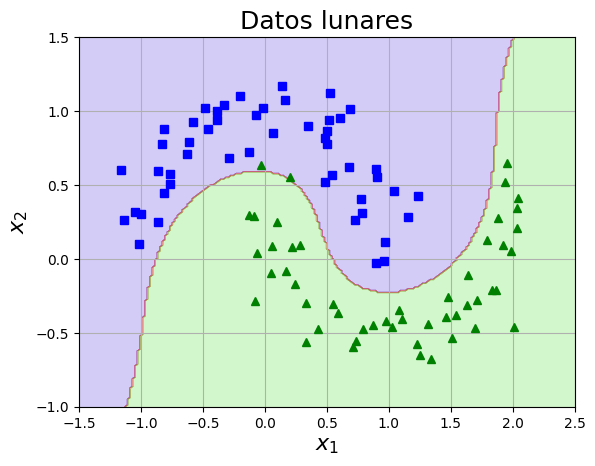

In [14]:
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

El siguiente gráfico muestra los límites de decisión del modelo. Debido a que agregamos grados polinómicos, los límites proyectados ahora son no lineales:

<div style="text-align:center;"><img style="width:50%;" src="./img/polynomial_svms.png" /></div>

### 2.1. Kernels Polinómicos

En grados polinómicos bajos, agregar características no permite manejar conjuntos de datos complejos, y para grados polinómicos altos terminamos agregando muchas características, lo que da como resultado un modelo muy complejo y lento.

Afortunadamente, cuando usamos SVM podemos aplicar una técnica matemática casi milagrosa llamada **truco del kernel**. El truco del kernel hace posible obtener el mismo resultado que si añadiéramos muchas características polinómicas sin añadirlas realmente.

En este punto es importante distinguir entre dos variantes del clasificador SVM que ofrece *scikit-learn*: **SVC** y **LinearSVC**, ya que a menudo se confunden.

* **SVC** es la implementación general del clasificador SVM.
  Permite usar kernels no lineales (por ejemplo, polinómico o RBF) y, por tanto, puede modelar fronteras de decisión muy complejas. Sin embargo, al trabajar internamente con la matriz de kernel, su coste computacional crece de forma cuadrática o cúbica con el número de muestras. Por este motivo es adecuado solo para datasets pequeños o medianos.

* **LinearSVC**, en cambio, está diseñado exclusivamente para problemas **lineales**.
  No admite kernels y utiliza un algoritmo de optimización diferente, mucho más eficiente, lo que le permite entrenarse en grandes conjuntos de datos. Es la mejor opción cuando creemos que las clases pueden separarse aproximadamente mediante un hiperplano, o cuando necesitamos escalar a miles o millones de ejemplos.

Por tanto:

* Si queremos **fronteras no lineales**, necesitamos **SVC** con un kernel adecuado.
* Si queremos **velocidad** o trabajar con datasets grandes, usamos **LinearSVC**, aun sabiendo que solo aprenderá fronteras lineales.

Vamos a probar el uso de kernels en el dataset *moons*:




In [15]:
from sklearn.svm  import SVC


In [16]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=300, noise=0.15)

In [17]:
poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])

El kernel polinómico calcula:

$
K(x, z) = (x \cdot z + r)^d
$

Esto significa:

* No creamos explícitamente características como $x_1^2$, $x_1x_2$…
* Pero matemáticamente el SVM se está comportando *como si* esas características existieran.
* Esto reduce tremendamente el coste computacional.

In [18]:
poly_kernel_svm_clf.fit(X, y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

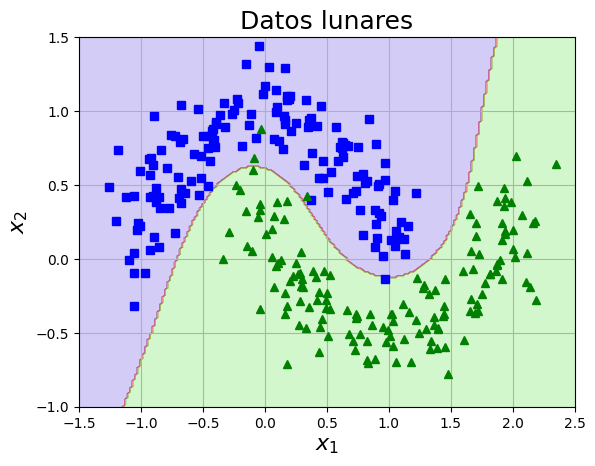

In [19]:
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

Este modelo entrena un clasificador SVM utilizando un kernel de features de **tercer grado**.
El kernel polinómico permite que el clasificador actúe *como si* estuviera trabajando en un espacio ampliado con todas las combinaciones polinómicas posibles hasta dicho grado, pero sin necesidad de generarlas explícitamente gracias al **truco del kernel**.

Si nuestro modelo se ajusta en exceso, es posible que deseemos **disminuir el grado** del polinomio, ya que los polinomios de grado alto tienden a producir fronteras de decisión más onduladas y adaptadas al ruido del dataset (*overfitting*).
Por el contrario, si se ajusta de manera insuficiente (subrepresenta la forma de los datos), puede ser una buena idea **aumentar el grado**, lo cual permite que la frontera sea más flexible y capture patrones más complejos.

El parámetro `coef0` (a veces llamado *r* en la literatura) controla en qué porcentaje el modelo está influenciado por los **términos de alto grado** frente a los **términos de bajo grado**.
En términos prácticos:

* Un `coef0` pequeño hace que predominen los términos de menor grado → frontera más suave.
* Un `coef0` grande acentúa los términos de alto grado → frontera más compleja y con mayor curvatura.

Este parámetro suele tener un impacto importante en datasets como *moons*, donde la curvatura de la frontera es relevante para separar las dos medias lunas.

La siguiente figura muestra el modelo previamente entrenado de **grado 3** (a la izquierda), frente a un modelo más complejo con kernel polinómico de **grado 10**.
La comparación ilustra cómo, al aumentar el grado, la frontera de decisión se vuelve mucho más intricada —capaz de ajustarse a detalles finos, pero también más propensa al sobreajuste—, mientras que grados más bajos tienden a generar fronteras más estables y generalizables.


<div style="text-align:center;"><img style="width:66%;" src="./img/kernel_trick.png" /></div>


**Tabla comparativa: LinearSVC vs SVC**

| Característica            | **LinearSVC**               | **SVC**                                                        |
| ------------------------- | --------------------------- | -------------------------------------------------------------- |
| Tipo de modelo            | Clasificador **lineal**     | Clasificador **lineal o no lineal** (según kernel)             |
| Soporte de kernels        | ❌ No admite kernels         | ✔️ Admite kernels (`'poly'`, `'rbf'`, `'sigmoid'`, `'linear'`) |
| Complejidad computacional | **O(n)** → muy rápido       | **O(n²)–O(n³)** → muy lento                                    |
| Dataset recomendado       | Grande o muy grande         | Pequeño o mediano                                              |
| Velocidad                 | ⭐⭐⭐⭐⭐                       | ⭐⭐                                                             |
| Memoria necesaria         | Baja                        | Alta (matriz kernel n×n)                                       |
| Riesgo de overfitting     | Bajo–medio                  | Medio–alto (según kernel)                                      |
| Flexibilidad del modelo   | Baja                        | Muy alta (fronteras no lineales)                               |
| Interpretación            | Más fácil (frontera lineal) | Puede ser compleja (según kernel)                              |
| Similar en regresión      | **LinearSVR**               | **SVR**                                                        |




## 3. Regresión SVM

Las SVM también admiten la regresión lineal y no lineal, pero para pasar de la clasificación a la regresión tenemos que invertir el objetivo. En lugar de intentar encajar la calle más grande posible entre dos clases mientras se limitan las infracciones de margen, la regresión SVM intenta encajar **tantas instancias como sea posible** en la calle mientras limita las infracciones de margen. El ancho de la calle está controlado por el hiperparámetro $ \epsilon $. A continuación se muestra un ejemplo:



<div style="text-align:center;"><img style="width:66%;" src="./img/SVM_regression.png" /></div>

Agregar más instancias al margen no afecta las predicciones del modelo; por lo tanto, se dice que el modelo es $ \epsilon $-insensible.

Vamos a implementar un regresor lineal `SVR` de `sklearn` (después de escalar y centrar los datos):

In [20]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Dataset artificial de regresión lineal
X = np.linspace(-5, 5, 200).reshape(-1, 1)
y = 3 * X.ravel() + 2 + np.random.randn(200) * 2   # recta + ruido


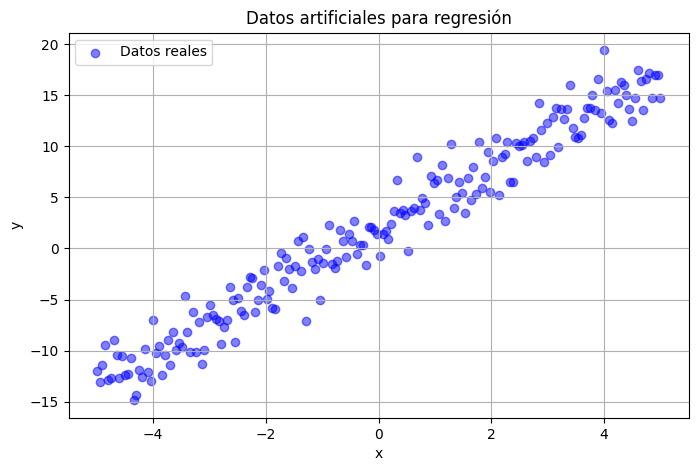

In [21]:
plt.figure(figsize=(8,5))
plt.scatter(X, y, color="blue", alpha=0.5, label="Datos reales")
plt.title("Datos artificiales para regresión")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()


In [22]:
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", LinearSVR(epsilon=1.5, C=1.0, random_state=42))
])




In [23]:
svm_reg.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', LinearSVR(epsilon=1.5, random_state=42))])

In [24]:
y_pred = svm_reg.predict(X)


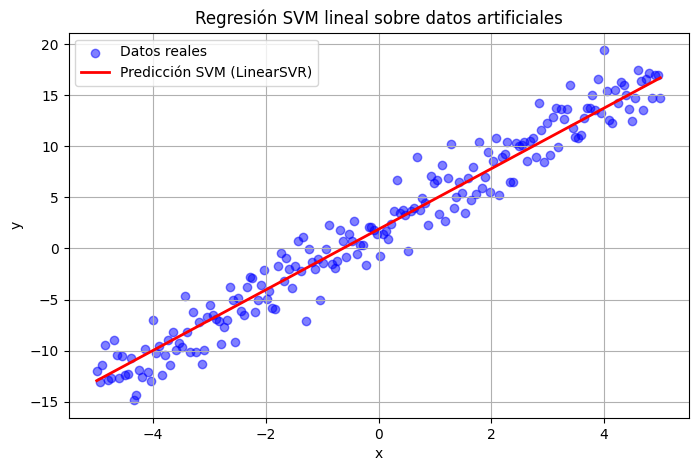

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

# Datos originales
plt.scatter(X, y, color="blue", alpha=0.5, label="Datos reales")

# Línea aprendida por LinearSVR
plt.plot(X, y_pred, color="red", linewidth=2, label="Predicción SVM (LinearSVR)")

plt.title("Regresión SVM lineal sobre datos artificiales")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


### 3.1 **Regresor lineal SVR**

Para abordar las tareas de regresión lineal, podemos usar un modelo SVM con kernel polinomial.

Creamos un conjunto de datos sintético donde la salida sigue una relación cuadrática con la entrada. Este dataset, con algo de ruido añadido, es ideal para mostrar cómo un SVR con kernel polinómico puede ajustarse a patrones no lineales.


In [26]:
import numpy as np

# 1) Dataset artificial cuadrático + ruido

np.random.seed(42)
X = np.linspace(-3, 3, 200).reshape(-1, 1)
y = 0.5 * X.ravel()**2 + 1 + np.random.randn(200) * 0.5


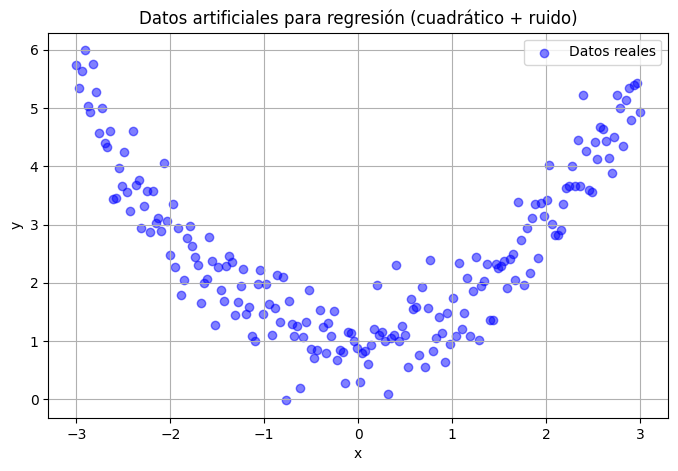

In [27]:
# 2) Scatter plot de los datos (ANTES de entrenar el modelo)

plt.figure(figsize=(8, 5))
plt.scatter(X, y, color="blue", alpha=0.5, label="Datos reales")
plt.title("Datos artificiales para regresión (cuadrático + ruido)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()


### Entrenamiento de un modelo SVR con kernel polinómico

Una vez generado el dataset artificial, definimos un modelo de regresión SVM capaz de capturar relaciones no lineales entre las variables. Para ello utilizamos un **SVR con kernel polinómico de grado 2**, que permite aprender funciones con forma parabólica. Incluimos también un `StandardScaler` dentro de un `Pipeline` para garantizar que todas las características estén correctamente escaladas antes del entrenamiento, algo esencial para el buen rendimiento de los SVM.



In [28]:
from sklearn.svm import SVR

# 3) Definir el modelo SVR con kernel polinómico (degree=2)

svm_poly_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel='poly', degree=2, C=100, epsilon=0.1, gamma='auto'))
])

En el modelo SVR con kernel polinómico utilizamos tres hiperparámetros clave que controlan el comportamiento del ajuste:

* **C = 100**
  Determina cuánto penaliza el modelo los errores fuera del margen $ \epsilon $.
  *Cuanto mayor es C*, más estrictamente intenta el SVR aproximarse a los datos, permitiendo una curva más ajustada pero con mayor riesgo de sobreajuste.

* **epsilon = 0.1**
  Define el tamaño del “tubo” $ \epsilon $-insensible alrededor de la función predicha.
  Los errores que caen dentro de este margen **no se penalizan**.
  Un valor pequeño $0.1$ hace que el modelo sea más sensible y trate de ajustarse con mayor precisión a los puntos.

* **gamma = 'auto'**
  Es un parámetro que afecta a la influencia de cada punto de entrenamiento en el kernel.
  Con `'auto'`, gamma se calcula como:

    $
    \gamma = \frac{1}{n_{\text{features}}}
    $

  En este caso, dado que solo hay 1 característica, gamma = 1.
  Esto controla la “anchura” de las curvas generadas por el kernel polinómico.



En el modelo SVR con kernel polinómico utilizamos tres hiperparámetros clave que controlan el comportamiento del ajuste:

* **C = 100**
  Determina cuánto penaliza el modelo los errores fuera del margen $ \epsilon $.
  *Cuanto mayor es C*, más estrictamente intenta el SVR aproximarse a los datos, permitiendo una curva más ajustada pero con mayor riesgo de sobreajuste.

* **epsilon = 0.1**
  Define el tamaño del “tubo” $ \epsilon $-insensible alrededor de la función predicha.
  Los errores que caen dentro de este margen **no se penalizan**.
  Un valor pequeño $0.1$ hace que el modelo sea más sensible y trate de ajustarse con mayor precisión a los puntos.

* **gamma = 'auto'**
  Es un parámetro que afecta a la influencia de cada punto de entrenamiento en el kernel.
  Con `'auto'`, gamma se calcula como:

    $
    \gamma = \frac{1}{n_{\text{features}}}
    $

  En este caso, dado que solo hay 1 característica, gamma = 1.
  Esto controla la “anchura” de las curvas generadas por el kernel polinómico.



In [29]:
# Entrenamiento del modelo
svm_poly_reg.fit(X, y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', SVR(C=100, degree=2, gamma='auto', kernel='poly'))])

In [30]:
# 4) Predicción sobre los mismos puntos X
y_pred = svm_poly_reg.predict(X)

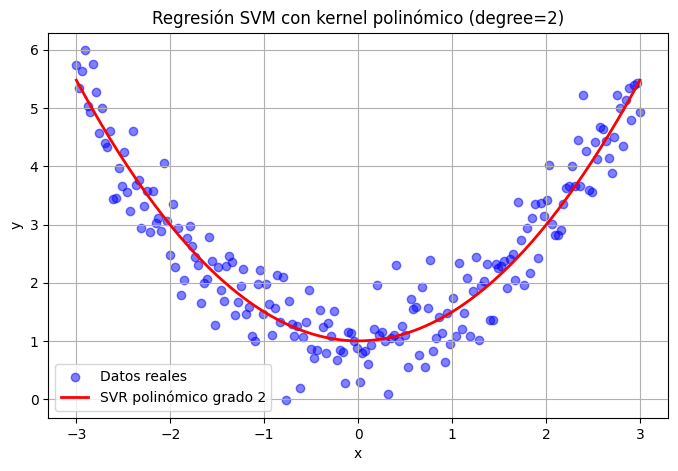

In [31]:
# 5) Dibujar de nuevo el scatter + la línea de regresión aprendida
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color="blue", alpha=0.5, label="Datos reales")
plt.plot(X, y_pred, color="red", linewidth=2, label="SVR polinómico grado 2")
plt.title("Regresión SVM con kernel polinómico (degree=2)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()


### **Conclusión: diferencia entre LinearSVR y SVR**

`LinearSVR` y `SVR` implementan ambos la regresión con máquinas de soporte vectorial, pero utilizan algoritmos muy distintos y están pensados para problemas diferentes.

* **LinearSVR** usa un método de optimización específico para modelos lineales.
  Es extremadamente rápido y escala bien incluso con decenas o cientos de miles de muestras. Solo puede aprender **relaciones lineales** entre las variables.

* **SVR**, en cambio, es la implementación completa del algoritmo basado en kernels.
  Puede aprender **relaciones no lineales** gracias al kernel polinómico, RBF u otros, pero su coste computacional crece de manera cuadrática o cúbica con el número de muestras, por lo que solo es práctico para datasets pequeños o medianos.


---

**Tabla comparativa: LinearSVR vs SVR**

| Característica            | **LinearSVR**         | **SVR**                                                       |
| ------------------------- | --------------------- | ------------------------------------------------------------- |
| Tipo de modelo            | Regressión **lineal** | Regresión **lineal o no lineal** (según kernel)               |
| Soporte de kernels        | ❌ No admite kernels   | ✔️ Admite kernels: `'poly'`, `'rbf'`, `'sigmoid'`, `'linear'` |
| Complejidad computacional | **O(n)** → muy rápido | **O(n²)–O(n³)** → muy lento                                   |
| Dataset recomendado       | Grande o muy grande   | Pequeño o mediano                                             |
| Velocidad                 | ⭐⭐⭐⭐⭐                 | ⭐⭐                                                            |
| Memoria necesaria         | Baja                  | Alta (matriz kernel n×n)                                      |
| Riesgo de overfitting     | Bajo–medio            | Medio–alto (según kernel y parámetros)                        |
| Flexibilidad del modelo   | Baja                  | Muy alta                                                      |
| Similar en clasificación  | **LinearSVC**         | **SVC**                                                       |





## 4. EXTRA: Similarity Features

Al margen de los kernels polinómicos, existe otra técnica habitual para abordar problemas no lineales llamada **“similarity features”**. Esta técnica consiste en agregar características adicionales calculadas mediante una **función de similitud**, la cual mide cuánto se parece cada instancia a uno o varios **puntos de referencia** específicos.

Por ejemplo, si tomamos el dataset visto anteriormente y agregamos dos puntos de referencia en $ x_1 = -2 $ y $ x_1 = 1 $, como se muestra en el gráfico de la izquierda:

<div style="text-align:center;"><img style="width:66%;" src="./img/similarity_measures.png" /></div>

Definimos la función de similitud como la **Función de Base Radial Gaussiana (RBF)** con $ \gamma = 0.3 $.
La función $ \phi $ es una función en forma de campana que toma valores:

* cercanos a **1** cuando la instancia $ x $ está cerca del punto de referencia $ l $,
* cercanos a **0** cuando $ x $ está lejos del punto de referencia.

Matemáticamente:

$
\phi(x, , l) = \exp(-\gamma \lVert x - l \rVert^2)
$

Después de definir la función de similitud, las nuevas características que añadimos al dataset son precisamente las **distancias suavizadas** (según la función RBF) entre cada instancia y los puntos de referencia elegidos.

Como se aprecia en el gráfico de la derecha, al representar las instancias en este nuevo espacio construido a partir de las “distancias a puntos de referencia”, los datos se vuelven **linealmente separables**. Es decir, al transformar el espacio mediante funciones de similitud, una frontera lineal en el nuevo espacio puede corresponder a una frontera no lineal en el espacio original.

Pero surge una pregunta fundamental: **¿cómo seleccionamos los puntos de referencia?**

El enfoque más simple es usar **todos los puntos de entrenamiento como puntos de referencia**. Esto transforma el espacio original de dimensión $ n $ a un nuevo espacio de dimensión $ m $, donde $ m $ es el número total de instancias del dataset.

Este aumento masivo de dimensiones:

* proporciona una gran capacidad para encontrar un separador lineal en el espacio transformado,
* pero tiene el inconveniente de que el coste computacional crece en la misma proporción,
* lo que puede generar problemas de rendimiento, especialmente si el número de instancias es grande.




### 4.1. Gaussian RBF Kernel

Al igual que el método de características polinómicas, el método de características de similitud puede ser útil en muchos algoritmos de ML. El problema es que con conjuntos de datos muy grandes, terminaremos con un espacio de características muy grande, pero una vez más tenemos el truco de Kernel para que parezca como si añadimos características adicionales.

Vamos a verlo con `sklearn`:

In [32]:
from sklearn.svm import SVC

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15)
import seaborn as sns
Cx = X[:, 0]
Cy = X[:, 1]

In [33]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=0.1, C=1000))
])

In [34]:
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=1000, gamma=0.1))])

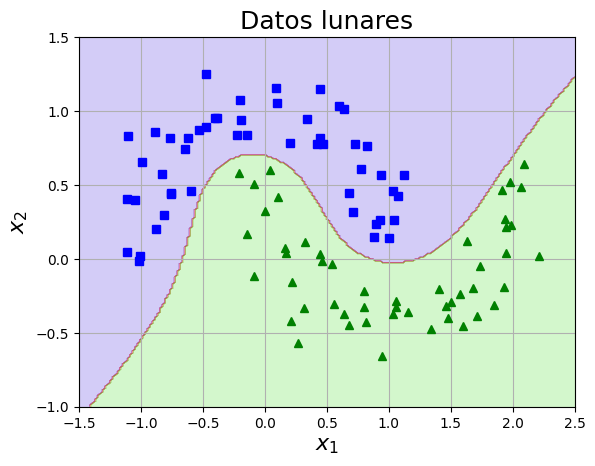

In [35]:
plot_predictions(rbf_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

A continuación tenemos el espacio de predicciones con las instancias del conjunto de entrenamiento (abajo a la izquierda está el modelo entrenado anteriormente). Los otros gráficos se corresponden a diferentes configuraciones de hiperparámetros:



<div style="text-align:center;"><img style="width:66%;" src="./img/training_rbfs.png" /></div>

El aumento de $\gamma$ hace que la curva en forma de campana sea más estrecha, el límite de decisión termina siendo más irregular, moviéndose alrededor de instancias individuales. Entonces $\gamma$ actúa como un hiperparámetro de regularización.
- El aumento de gamma aumenta la sensibilidad del modelo (puede dar lugar a un sobreajuste).
- la disminución de gamma aumenta el sesgo del modelo (puede conducir a un ajuste insuficiente)

Siempre deberíamos probar primero el kernel lineal, y si el conjunto de entrenamiento no es demasiado grande, entonces podríamos probar el kernel RBF gaussiano.

## Ejercicios:

Responde a las siguientes preguntas cortas:

<div style="background-color:green;color:white">

<br>


1. ¿Qué es un vector de soporte?
2. ¿Es necesario escalar las features cuando usamos SVM? ¿Por qué?
3. Supongamos que has entrenado un clasificador SVM con Kernel Polinómicos, pero parece que no se ajusta bien a los datos de entrenamiento. ¿Qué harías?

<br>

1. Un vector de soporte es una observación del conjunto de datos que se encuentra más cercana al margen de separación entre clases. Estos puntos son fundamentales porque determinan la posición y la orientación del hiperplano de decisión. Si se eliminan, el modelo SVM cambiaría su frontera de clasificación.

2. Sí, es necesario escalar las features cuando se utilizan SVM. Esto se debe a que el algoritmo se basa en el cálculo de distancias entre los datos. Si las variables tienen escalas muy diferentes, aquellas con valores más grandes dominarán el proceso de entrenamiento, afectando negativamente al rendimiento del modelo. El escalado asegura que todas las features contribuyan de forma equilibrada.

3. En este caso, ajustaría los hiperparámetros del modelo. En concreto, probaría a aumentar el grado del kernel polinómico para incrementar la complejidad del modelo, modificaría el parámetro C para controlar la penalización de errores y ajustaría gamma si fuera necesario. También verificaría que los datos estén correctamente escalados. Si el rendimiento sigue siendo bajo, consideraría cambiar a otro kernel más flexible, como el kernel RBF.

### **4. Clasificación lineal con LinearSVC y SVC**

En este ejercicio generaremos un dataset sintético linealmente separable, entrenaremos dos clasificadores SVM lineales (`LinearSVC` y `SVC(kernel='linear')`) y compararemos sus fronteras de decisión.
Debes **completar el código y los huecos marcados** además de responder brevemente a algunas cuestiones.


 #### **4.1. Generación del dataset**

Generamos dos nubes de puntos que representarán dos clases separables linealmente.

<div style="background-color:green;color:white">

TAREA: completa las líneas marcadas con *#COMPLETAR*

<br>

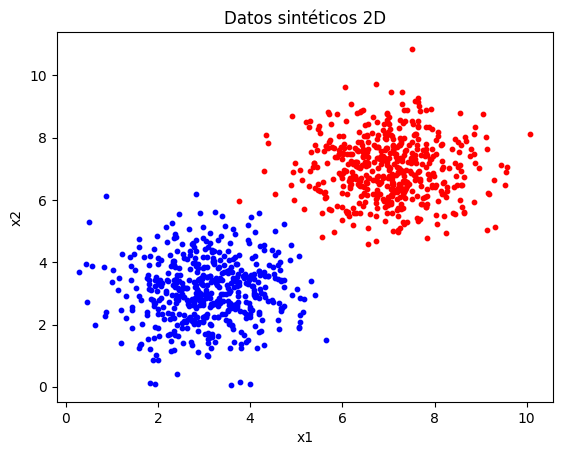

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC

np.random.seed(42)

# Clase 1 (roja)
d1 = np.concatenate((
    np.random.normal(loc=7, scale=1, size=(500, 2)),
    np.ones((500, 1))
), axis=1)

# Clase 0 (azul)
d2 = np.concatenate((
    np.random.normal(loc=3, scale=1, size=(500, 2)),
    np.zeros((500, 1))
), axis=1)

# COMBINAR LOS DOS GRUPOS
d = np.concatenate((d1, d2), axis=0)

# MEZCLAR (shuffle)
## COMPLETAR ##
np.random.shuffle(d)

# REPRESENTACIÓN
plt.scatter(d1[:,0], d1[:,1], s=10, c='red')
plt.scatter(d2[:,0], d2[:,1], s=10, c='blue')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Datos sintéticos 2D")
plt.show()

---

<div style="background-color:green;color:white">

<br>

#### **4.2. Separación entrenamiento / prueba**

<br>

In [37]:
from sklearn.model_selection import train_test_split

X = d[:, :2]   # características
y = d[:, 2:]   # etiquetas

# COMPLETAR: hacer un split del 20% para test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800, 1), (200, 1))

---

<div style="background-color:green;color:white">

<br>

#### **4.3. Entrena un modelo LinearSVC**

<br>

In [38]:
# Crear el modelo Linear SVC
## COMPLETAR ##
model = LinearSVC()

In [39]:
# ENTRENAR EL MODELO
## COMPLETAR ##
model.fit(X_train, y_train.ravel())

LinearSVC()

In [40]:
# EVALUAR
acc_linear = model.score(X_test, y_test)
acc_linear

1.0

---

<div style="background-color:green;color:white">

<br>

#### **4.4. Visualización de la frontera de decisión (LinearSVC)**

<br>

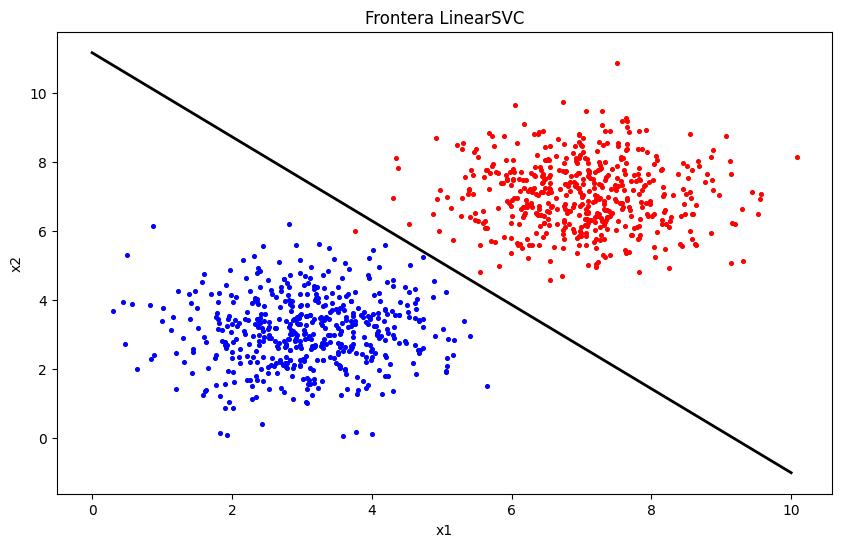

In [41]:
plt.figure(figsize=(10,6))
plt.scatter(d1[:,0], d1[:,1], c='red', s=7)
plt.scatter(d2[:,0], d2[:,1], c='blue', s=7)

# Parámetros del hiperplano
w = model.coef_[0]            # vector normal del hiperplano
a = -w[0] / w[1]              # pendiente

xx = np.linspace(0, 10)
yy = a * xx - (model.intercept_[0]) / w[1]     # COMPLETAR

plt.plot(xx, yy, "k-", linewidth=2)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Frontera LinearSVC")
plt.show()

---

<div style="background-color:green;color:white">

<br>

#### **Entrenamiento con SVC(kernel='linear')**

<br>

In [42]:
svc_clf = SVC(kernel="linear", C=1.0, gamma="auto")   # COMPLETAR

In [43]:
# ENTRENAR
svc_clf.fit(X_train, y_train.ravel())       # COMPLETAR

SVC(gamma='auto', kernel='linear')

In [44]:
# EVALUAR
acc_svc = svc_clf.score(X_test, y_test)
acc_svc

1.0

---

<div style="background-color:green;color:white">

<br>

#### **4.6. Visualización de la frontera de SVC**

<br>

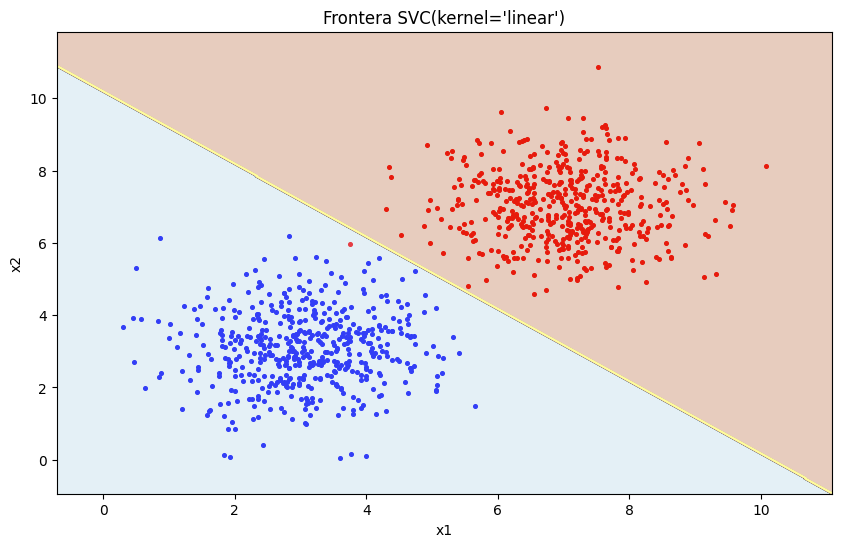

In [45]:
h = 0.02
x_min, x_max = d[:,0].min() - 1, d[:,0].max() + 1
y_min, y_max = d[:,1].min() - 1, d[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,6))
plt.scatter(d1[:,0], d1[:,1], c='red', s=7)
plt.scatter(d2[:,0], d2[:,1], c='blue', s=7)

# DIBUJAR LA FRONTERA
## COMPLETAR ##
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Frontera SVC(kernel='linear')")
plt.show()

---

<div style="background-color:green;color:white">

<br>

#### ***4.7. Comparación entre LinearSVC y SVC***

1. ¿Las fronteras son idénticas?
2. ¿En qué se diferencian visualmente?
3. ¿Por qué ocurre esto? (pistas: función de pérdida, valor de C)
4. ¿Podrían ser exactamente iguales ajustando parámetros?

<br>

1. En este ejercicio, las fronteras de decisión coinciden visualmente.

2. 
- **LinearSVC** muestra únicamente la línea del hiperplano, calculada a partir de los coeficientes del modelo.
- **SVC con kernel lineal** permite visualizar además las regiones de decisión, lo que hace más evidente de qué lado de la frontera cae cada punto.

3.
**Función de pérdida**:
- LinearSVC utiliza hinge loss o squared hinge loss.
- SVC utiliza una formulación basada en el problema dual con hinge loss clásico.

**Optimización**:
- **LinearSVC** está optimizado para eficiencia en datasets grandes y no calcula explícitamente los vectores de soporte.
- **SVC** sí calcula los vectores de soporte y optimiza el margen de forma más exacta.

**Parámetro C**:
- Aunque ambos usan C, su interpretación y efecto práctico no es exactamente el mismo en ambas implementaciones.

---

<div style="background-color:green;color:white">

<br>

#### ***4.8. Ajuste para obtener modelos equivalentes***

Ahora ajustamos **LinearSVC** para que use la función de pérdidas hinge y el mismo C que SVC.


<br>

In [46]:
C = 1.0     # mismo valor que en SVC

model2 = LinearSVC(C=C, loss="squared_hinge")
model2.fit(X_train, y_train.ravel())

LinearSVC()

In [47]:
model2.score(X_test, y_test)

1.0

---

<div style="background-color:green;color:white">

<br>

#### ***4.9. Visualización de la nueva frontera LinearSVC***

Ahora ajustamos **LinearSVC** para que use la función de pérdidas hinge y el mismo C que SVC.

<br>

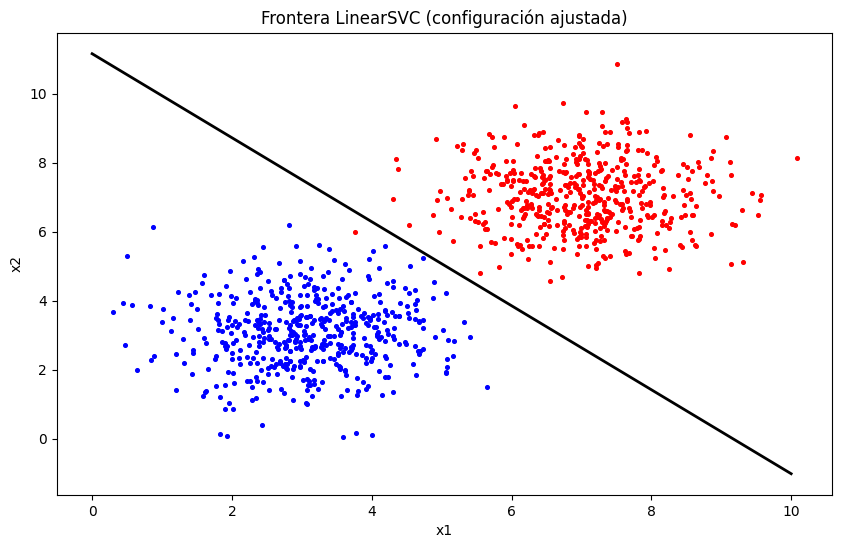

In [48]:
plt.figure(figsize=(10,6))
plt.scatter(d1[:,0], d1[:,1], c='red', s=7)
plt.scatter(d2[:,0], d2[:,1], c='blue', s=7)

w = model2.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(0, 10)
yy = a * xx - (model2.intercept_[0]) / w[1]

plt.plot(xx, yy, "k-", linewidth=2)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Frontera LinearSVC (configuración ajustada)")
plt.show()

---

<div style="background-color:green;color:white">

<br>

#### ***4.10. Reflexión final***

* ¿Coincide ahora la frontera de LinearSVC con la de SVC?
* ¿Sigue habiendo ligeras diferencias? ¿Por qué?
  (pista: *distintos algoritmos internos: liblinear vs libsvm*)

<br>

1. Tras el ajuste, la frontera de LinearSVC coincide visualmente con la de SVC.

2. Aunque internamente usan algoritmos distintos (liblinear vs libsvm), en este conjunto de datos linealmente separable no se aprecian diferencias.

### 5. **Ejercicio 5 — Entrena un Regresor SVM sobre el dataset California Housing (SVR)**

En este ejercicio trabajaremos con el dataset real **California Housing**, uno de los clásicos para tareas de regresión. Vamos a:

1. Cargar el dataset.
2. Escalar correctamente sus variables.
3. Entrenar un **SVR** (SVM para regresión).
4. Evaluar el rendimiento del modelo.
5. Completar código y reflexionar sobre los resultados.

#### **5.1. Carga del dataset**


In [49]:
from sklearn import datasets
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from pprint import pprint

# Cargar dataset California Housing
dataset = datasets.fetch_california_housing()

# Descripción del dataset
pprint(dataset.DESCR)

X = dataset.data
y = dataset.target

('.. _california_housing_dataset:\n'
 '\n'
 'California Housing dataset\n'
 '--------------------------\n'
 '\n'
 '**Data Set Characteristics:**\n'
 '\n'
 ':Number of Instances: 20640\n'
 '\n'
 ':Number of Attributes: 8 numeric, predictive attributes and the target\n'
 '\n'
 ':Attribute Information:\n'
 '    - MedInc        median income in block group\n'
 '    - HouseAge      median house age in block group\n'
 '    - AveRooms      average number of rooms per household\n'
 '    - AveBedrms     average number of bedrooms per household\n'
 '    - Population    block group population\n'
 '    - AveOccup      average number of household members\n'
 '    - Latitude      block group latitude\n'
 '    - Longitude     block group longitude\n'
 '\n'
 ':Missing Attribute Values: None\n'
 '\n'
 'This dataset was obtained from the StatLib repository.\n'
 'https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html\n'
 '\n'
 'The target variable is the median house value for California districts,

---

<div style="background-color:green;color:white">

<br>

* ¿Qué representan X y y?
* ¿Qué tipo de problema es este?
* ¿Qué dimensiones tiene X (nº muestras × nº características)?

<br>

1. X contiene las 8 variables predictoras del dataset California Housing y y el valor medio de las viviendas.

2. Es un problema de regresión, ya que la variable objetivo es continua.

3. X tiene dimensiones 20640 × 8 (muestras × características).

#### **5.2. División entrenamiento / validación**

<div style="background-color:green;color:white">

<br>

completar los parámetros de *train_test_split*

<br>

In [50]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### **5.3. Escalado de datos**

<div style="background-color:green;color:white">

<br>

**IMPORTANTE:**
SVR **siempre requiere escalado** de características.
Sin escalado, su rendimiento es pésimo.

<br>


In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)

#### **5.4. Entrena el modelo SVR**

<div style="background-color:green;color:white">

<br>

**TAREA: completar parámetros del modelo para experimentar (kernel, C, epsilon…).**

<br>

In [52]:
# Crear el modelo SVR 
regressor = SVR(kernel='rbf', C=100, epsilon=0.1)

regressor.fit(X_train_scaled, y_train)

SVR(C=100)

#### **5.5. Evalúa el modelo**

<div style="background-color:green;color:white">

<br>

**TAREA: completar la llamada al método score con los datos escalados.**


<br>

In [53]:
# Evaluar el modelo
score = regressor.score(X_val_scaled, y_val)
score

0.755723128476697

`score` en regresión devuelve **R² (coeficiente de determinación)**.
Valores típicos:

* 1.0 → ajuste perfecto
* 0.7–0.8 → buen modelo
* < 0 → el modelo es peor que predecir la media

#### **5.6. Reflexión guiada**

<div style="background-color:green;color:white">

<br>

**a) Explica brevemente por qué SVR necesita escalado obligatorio.**


**b) Prueba diferentes hiperparámetros del modelo:**
Los alumnos deben modificar código:

<br>


1. SVR se basa en distancias entre puntos, por lo que si las variables no están escaladas, las que tienen valores más grandes dominan el modelo y empeoran su rendimiento.

In [54]:
regressor1 = SVR(kernel='rbf', C=10, epsilon=0.1, gamma='scale')
regressor1.fit(X_train_scaled, y_train)
regressor1.score(X_val_scaled, y_val)

0.7529816153515758

In [55]:
# C = 1
regressor2 = SVR(kernel='rbf', C=1, epsilon=0.1, gamma='scale')
regressor2.fit(X_train_scaled, y_train)
regressor2.score(X_val_scaled, y_val)

0.7275639524733045

In [56]:
# C = 100
regressor3 = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale')
regressor3.fit(X_train_scaled, y_train)
regressor3.score(X_val_scaled, y_val)

0.755723128476697

<div style="background-color:green;color:white">

<br>

**TAREA:**

* Cambiar C: 1, 10, 100
* Cambiar epsilon: 0.1, 0.5
* Cambiar kernel: 'linear', 'poly', 'rbf'

<br>

In [57]:
# epsilon = 0.1
regressor4 = SVR(kernel='rbf', C=10, epsilon=0.1, gamma='scale')
regressor4.fit(X_train_scaled, y_train)
regressor.score(X_val_scaled, y_val)


0.755723128476697

In [58]:
# epsilon = 0.5
regressor5 = SVR(kernel='rbf', C=10, epsilon=0.5, gamma='scale')
regressor5.fit(X_train_scaled, y_train)
regressor5.score(X_val_scaled, y_val)

0.7518701750707981

In [59]:
# kernel linear
regressor6 = SVR(kernel='linear', C=10, epsilon=0.1)
regressor6.fit(X_train_scaled, y_train)
regressor6.score(X_val_scaled, y_val)

0.5579606814564861


<br>

<div style="background-color:green;color:white">
<br>

**c) Completa la tabla con los resultados obtenidos.**

| Kernel |  C | epsilon | R² obtenido |
| ------ | -  | ------- | ----------- |
|   rbf  |10  |   0.1   |  0.75298    |
|   rbf  | 1  |   0.1   |  0.72756    |
|   rbf  |100 |   0.1   |  0.75572    |
|   rbf  |10  |   0.5   |  0.75187    |
| linear |10  |   0.1   |  0.55796    |


**d) Razona cuál configuración parece más adecuada para este dataset y por qué.**

<br>

La configuración que ofrece mejor rendimiento es SVR con kernel RBF, C = 100 y epsilon = 0.1, ya que es la que obtiene el mayor valor de R² entre las configuraciones probadas.

#### **5.7. EXTRA (Opcional)**

Para profundizar:

<div style="background-color:green;color:white">

<br>

**Añadir código para GridSearchCV y seleccionar los mejores hiperparámetros**:

<br>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

svr = SVR()

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [1, 10, 100],
    'epsilon': [0.1, 0.5],
    'gamma': ['scale']
}

grid = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

grid.best_params_


### 6. **Ejercicio EXTRA — Clasificación de dígitos MNIST con SVM (One-vs-Rest)**

En este ejercicio entrenarás un **clasificador SVM** para identificar los 10 dígitos del conjunto de datos **MNIST**.

Un clasificador SVM es binario por naturaleza, por lo que scikit-learn aplica automáticamente la estrategia **One-vs-Rest (OvR)** para resolver problemas multiclase: entrenará un clasificador por cada dígito (0–9) y decidirá la clase final según cuál produzca el valor de decisión más alto.

Dado que entrenar SVM sobre MNIST puede ser costoso, utilizaremos un subconjunto reducido para realizar pruebas rápidas y comprender el proceso, y después podrás experimentar con más datos.

#### 1. **Carga del dataset MNIST**

Usamos la versión incluida en `sklearn.datasets`.

In [63]:
from sklearn.datasets import fetch_openml
import numpy as np

# Descargar MNIST (70 000 imágenes de 28x28)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist.data
y = mnist.target.astype(np.int8)

X.shape, y.shape

((70000, 784), (70000,))

<div style="background-color:green;color:white">

<br>

* ¿Por qué convertimos *y* a *int8*?
* ¿Cuál es el tamaño (n_samples, n_features) de MNIST?

<br>

1. Porque las etiquetas de MNIST son clases (0–9) y deben ser valores enteros, no strings. Convertirlas a int8 facilita el entrenamiento de clasificadores y reduce el uso de memoria.

2.
- n_samples = 70 000
- n_features = 784 (28 × 28 píxeles por imagen)

#### 2. **Normalización de los datos**

<div style="background-color:green;color:white">

<br>

Los SVM funcionan **muchísimo mejor** cuando los datos están escalados.


<br>

In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

#### 3. **División entrenamiento / validación**

<div style="background-color:green;color:white">

<br>

* Completar ambos *train_test_split*
* Explicar por qué usamos un subconjunto (velocidad / coste computacional)

<br>

In [65]:
from sklearn.model_selection import train_test_split

# Usamos un conjunto más pequeño para pruebas rápidas
X_small, _, y_small, _ = train_test_split(
    X_scaled, y, test_size=0.90, random_state=42
)

# AHORA dividimos el subconjunto en train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42    # COMPLETAR
)

X_train.shape, X_val.shape

((5600, 784), (1400, 784))

- Se usa un subconjunto para reducir el coste computacional.

- MNIST completo es muy grande para SVM.

- El subconjunto permite pruebas rápidas manteniendo resultados representativos.

#### 4.  **Entrenar un clasificador SVM lineal (rápido)**

Primero probamos con **LinearSVC** para tener una referencia.

<div style="background-color:green;color:white">

**completa hiperparámetros y *.fit()*:**

<br>

* Probar diferentes valores de C: 1, 5, 10
* Anotar resultados (pequeña tabla)

<br>

In [66]:
from sklearn.svm import LinearSVC

lin_svm = LinearSVC(C=1, loss="hinge")  # COMPLETAR

lin_svm.fit(X_train, y_train)                 # COMPLETAR

lin_svm.score(X_val, y_val)

/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8442857142857143

In [67]:
# C = 5
lin_svm1 = LinearSVC(C=5, loss="hinge")
lin_svm1.fit(X_train, y_train)
lin_svm1.score(X_val, y_val)

/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8221428571428572

In [68]:
# C = 10
lin_svm2 = LinearSVC(C=10, loss="hinge")
lin_svm2.fit(X_train, y_train)
lin_svm2.score(X_val, y_val)

/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.825

| Modelo     | C  |     r2    |
|------------|----|-----------|
| LinearSVC  | 1  | 0.8442857142857143 |
| LinearSVC  | 5  | 0.8221428571428572 |
| LinearSVC  | 10 | 0.825 |

#### 5.  **Entrenar un SVM con kernel RBF (más preciso pero lento)**

El kernel RBF suele dar mejor precisión en MNIST, pero es MUCHO más lento.

Por eso entrenaremos también una versión reducida.

<div style="background-color:green;color:white">

completar los parámetros y entrenar

Sugerencias para probar (pero debes elegir):**

* C = 2, 5
* gamma = "scale" o 0.01

<br>



In [69]:
from sklearn.svm import SVC

rbf_svm = SVC(
    kernel="rbf",
    C=5,            # COMPLETAR
    gamma="scale"        # COMPLETAR
)

rbf_svm.fit(X_train, y_train)

rbf_svm.score(X_val, y_val)

0.9421428571428572

#### 6.  **Comparación y reflexión**

 **Rellenar esta tabla con tus resultados reales:**

| Modelo    | C | gamma | Precisión Validación |
| --------- | - | ----- | -------------------- |
| LinearSVC |   |       |        0.844         |
| SVC RBF   | 5 | scale |        0.9421        |

<br>

<div style="background-color:green;color:white">

* ¿Qué modelo obtiene mejor precisión?
* ¿Cuál tarda más en entrenarse? ¿Por qué?
* ¿Tiene sentido entrenar un SVM RBF con los 70 000 ejemplos completos?

<br>

1. El SVC con kernel RBF.

2. SVC RBF tarda más, porque el kernel RBF necesita calcular similitudes entre muchas muestras (el coste crece mucho con el número de datos). LinearSVC es lineal y está optimizado para datasets grandes.

3. En general no, suele ser demasiado lento y costoso en memoria/tiempo. Para MNIST completo es más razonable usar LinearSVC u otros modelos escalables

#### 7.  **(Extra) Entrenar con un conjunto mayor**



<div style="background-color:green;color:white">

completar este bloque si quieres más precisión

<br>

In [70]:
# Ampliar el subconjunto
X_big, _, y_big, _ = train_test_split(
    X_scaled, y, test_size=0.75, random_state=42
)

# ENTRENAR nuevamente (completar)
rbf_svm.fit(X_big, y_big)
rbf_svm.score(X_val, y_val)

0.9978571428571429

#### 8.  **(Extra) Probar con nuevos números distintos modelos**


1.  **Abrir Paint:** Abre el programa Microsoft Paint.
2.  **Configurar el lienzo:**
      * No intentes dibujar en 28x28 píxeles (es demasiado pequeño para el ratón).
      * Haz un cuadrado cómodo, por ejemplo **300x300 píxeles**. (Puedes ajustar el tamaño arrastrando las esquinas del lienzo blanco).
3.  **Poner el Fondo Negro:**
      * Selecciona la herramienta **Relleno de color** (el ícono del bote de pintura).
      * Selecciona el color **Negro** en la paleta.
      * Haz clic en el lienzo blanco. Ahora todo debería ser negro.
4.  **Configurar el Pincel (Importante):**
      * Selecciona la herramienta **Pincel** (recomiendo el primero, el sólido).
      * Selecciona el color **Blanco** en la paleta.
      * **Grosor:** Cambia el tamaño al **máximo** (la línea más gorda). MNIST usa trazos gruesos; si dibujas fino, el modelo fallará.
5.  **Dibujar:**
      * Dibuja un número (del 0 al 9) en el centro. Intenta que ocupe una buena parte del lienzo, pero sin tocar los bordes.
6.  **Guardar:**
      * Ve a `Archivo` \> `Guardar como` \> `Imagen PNG`.
      * Nómbralo `dibujo.png`.
      * Guárdalo en la **misma carpeta** donde tienes tu archivo de Python (.ipynb o .py).

-----


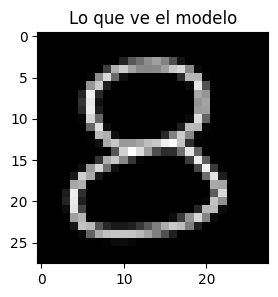

Predicción: 1


In [71]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 1. Cargar la imagen
img = Image.open("dibujo.png").convert("L")

# 2. Invertir colores -> Si no lo dibujas con fondo negro
# img = Image.eval(img, lambda x: 255 - x)  

# 3. Redimensionar a 28x28
img = img.resize((28, 28))

# 4. Convertir a array y normalizar
img_arr = np.array(img) / 255.0

# 5. Visualizar para confirmar
plt.figure(figsize=(3,3))
plt.imshow(img_arr, cmap="gray")
plt.title("Lo que ve el modelo")
plt.show()

# 6. Predecir
X_digit = img_arr.reshape(1, -1)
# (Asegúrate de escalar si tu modelo usa scaler)
X_digit_scaled = scaler.transform(X_digit) 

# Añade aquí tu modelo entrenado
pred = rbf_svm.predict(X_digit_scaled)[0]
print("Predicción:", pred)

#### 7.  **Conclusión Final del Ejercicio**

<div style="background-color:green;color:white">

* ¿Cuál hiperparámetro consideras más importante: C o gamma?
* ¿Cómo influye el escalado en el rendimiento del SVM?
* ¿Qué precisión máxima has logrado?

<br>

1. Ambos son importantes, pero gamma es clave en el SVM con kernel RBF porque controla la complejidad de la frontera de decisión. Un valor mal ajustado de gamma puede provocar sobreajuste o subajuste, incluso aunque C sea adecuado.

2. El escalado es fundamental, ya que el SVM se basa en distancias entre muestras. Sin escalado, las características con mayor rango dominan el modelo y el rendimiento cae drásticamente.

3. La precisión máxima obtenida es de aproximadamente 0.997, utilizando un SVM con kernel RBF entrenado con un conjunto de datos mayor.